In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
import math
from pathlib import Path
from collections import defaultdict
import statistics

import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import lpips
import torch
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF
from pydantic import BaseModel

from qwenimage.reporting import ExperimentSet, SetData, compare_lpips
from qwenimage.experiment import ExperimentConfig
from qwenimage.experiments.experiments_qwen import ExperimentRegistry

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
TMA benchmarks will be running without grid constant TMA descriptor.
2025-11-15 00:25:33.767946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the envi

In [3]:



def compare_sets(experiment_set:ExperimentSet, sort_by_mean=False, loss_fn=None):
    original_data = SetData(name=experiment_set.original)
    comparison_data = [SetData(name=comp) for comp in experiment_set.comparisons]

    if loss_fn is None:
        loss_fn = lpips.LPIPS(net='alex')  # or 'vgg' or 'squeeze'
        if torch.cuda.is_available():
            loss_fn = loss_fn.cuda()

    all_set_errors = defaultdict(list)
    for i in range(len(original_data)):
        for comp in comparison_data:
            lpips_error = compare_lpips(loss_fn, original_data[i], comp[i])
            all_set_errors[comp.name].append(lpips_error)
    
    error_stat_list = []
    for name, errors in all_set_errors.items():
        err_mean = statistics.mean(errors)
        err_std = statistics.stdev(errors)
        err_len = len(errors)
        error_stat_list.append({
            'name': f"{name}",
            'mean': err_mean,
            'std': err_std,
            'len': err_len
        })
        
    err_df = pd.DataFrame(error_stat_list)
    report_dir = ExperimentConfig().report_dir
    err_df.to_csv(report_dir / f"{experiment_set.original}_{'_'.join(experiment_set.comparisons)[:100]}.csv")
    
    if sort_by_mean:
        err_df = err_df.sort_values('mean', ascending=False)


    fig, ax = plt.subplots(figsize=(12, 6))
    x_pos = range(len(err_df))

    # bar_x = err_df["name"]
    bar_h = err_df["mean"]
    bar_std = err_df["std"]
    bars = ax.bar(
        x_pos, bar_h, yerr=bar_std, 
        capsize=12, alpha=0.7, edgecolor='black'
    )

    ax.set_xlabel('LPIPS error for experiment type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Error', fontsize=12, fontweight='bold')
    ax.set_title(f"LPIPS comparison", 
                    fontsize=14, fontweight='bold')
    

    ax.set_xticks(x_pos)
    ax.set_xticklabels(
        # [row['experiment'] for _, row in plot_data.iterrows()], 
        err_df["name"],
        rotation=15, ha='right', fontsize=12
    )

    ax.grid(axis='y', alpha=0.3)

    
    for i, (idx, row) in enumerate(err_df.iterrows()):        
        ax.text(i - 0.2, row['mean'] + 0.01, f"{row['mean']:.3f}", 
                ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()

    plot_path = report_dir / f"{experiment_set.original}_{'_'.join(experiment_set.comparisons)[:100]}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

    plt.show()
    


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


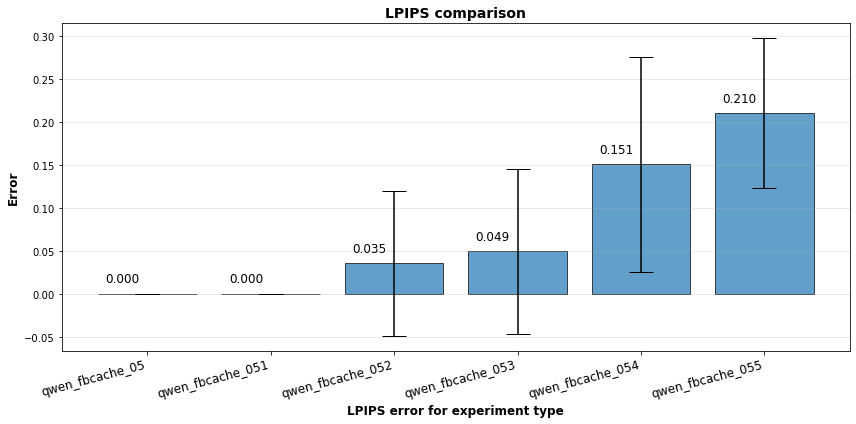

In [4]:
compare_sets(ExperimentSet.create(
    "qwen_base",
    "qwen_fbcache_05",
    "qwen_fbcache_051",
    "qwen_fbcache_052",
    "qwen_fbcache_053",
    "qwen_fbcache_054",
    "qwen_fbcache_055",
))


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


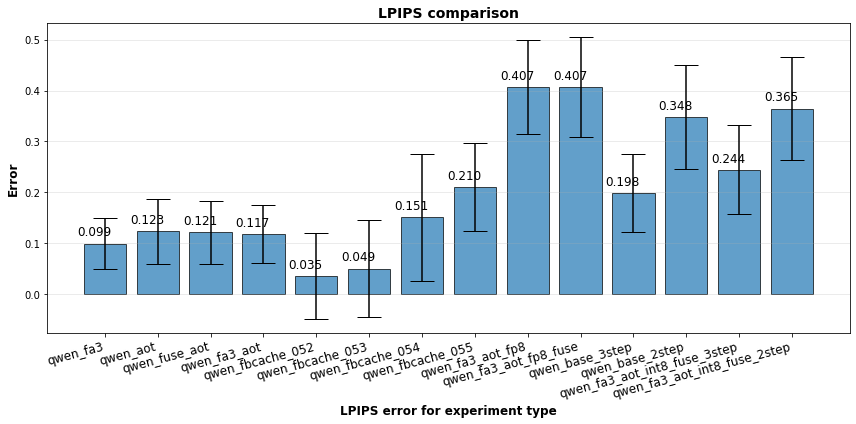

In [5]:
experiment_names = [    
    "qwen_base",
    "qwen_fa3",
    "qwen_aot",
    "qwen_fuse_aot",
    "qwen_fa3_aot",

    "qwen_fbcache_052",
    "qwen_fbcache_053",
    "qwen_fbcache_054",
    "qwen_fbcache_055",

    "qwen_fa3_aot_fp8",
    "qwen_fa3_aot_fp8_fuse",

    "qwen_base_3step",
    "qwen_base_2step",
    "qwen_fa3_aot_int8_fuse_3step",
    "qwen_fa3_aot_int8_fuse_2step"


]

compare_sets(ExperimentSet.create(
    *experiment_names
))


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


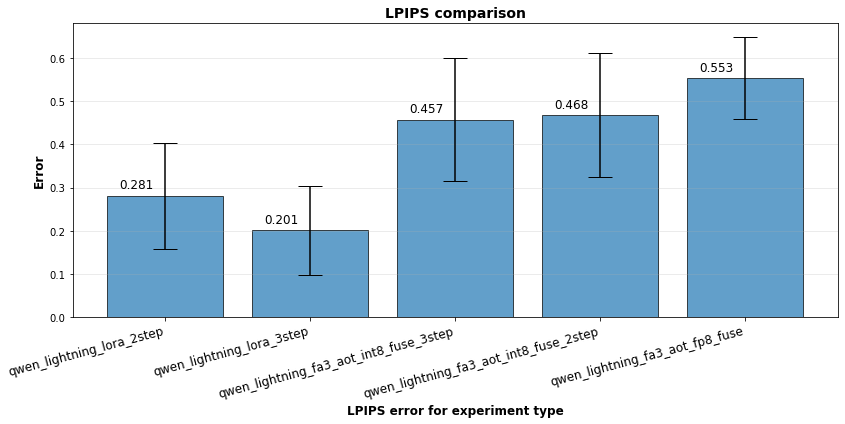

In [6]:
compare_sets(ExperimentSet.create(
    "qwen_lightning_lora",
    "qwen_lightning_lora_2step",
    "qwen_lightning_lora_3step",
    "qwen_lightning_lora_2step",
    "qwen_lightning_fa3_aot_int8_fuse_3step",
    "qwen_lightning_fa3_aot_int8_fuse_2step",
    "qwen_lightning_fa3_aot_fp8_fuse",
))

In [7]:
from typing import Literal


def compare_sets_with_timing(experiment_set: ExperimentSet, profile_target: str = "loop", sort_by="time", loss_fn=None, match_strategy:Literal["equal", "contain"]="equal"):
    """
    Create dual-axis bar plot with LPIPS error (left) and profile time (right) for each experiment.
    
    Args:
        experiment_set: ExperimentSet with original and comparison experiments
        profile_target: Which profile target to plot timing for (e.g., "loop", "run_once")
        sort_by: Sort experiments by "time", "lpips", or None
        loss_fn: LPIPS loss function (will create if None)
    """
    # Get LPIPS data
    original_data = SetData(name=experiment_set.original)
    comparison_data = [SetData(name=comp) for comp in experiment_set.comparisons]

    if loss_fn is None:
        loss_fn = lpips.LPIPS(net='alex')
        if torch.cuda.is_available():
            loss_fn = loss_fn.cuda()

    all_set_errors = defaultdict(list)
    for i in range(len(original_data)):
        for comp in comparison_data:
            lpips_error = compare_lpips(loss_fn, original_data[i], comp[i])
            all_set_errors[comp.name].append(lpips_error)
    
    lpips_stats = []
    # Add the original experiment with LPIPS = 0.0 (compared to itself)
    lpips_stats.append({
        'experiment': experiment_set.original,
        'lpips_mean': 0.0,
        'lpips_std': 0.0
    })
    # Add comparison experiments
    for name, errors in all_set_errors.items():
        err_mean = statistics.mean(errors)
        err_std = statistics.stdev(errors)
        lpips_stats.append({
            'experiment': name,
            'lpips_mean': err_mean,
            'lpips_std': err_std
        })
    
    lpips_df = pd.DataFrame(lpips_stats)
    
    # Get timing data
    report_dir = ExperimentConfig().report_dir
    timing_data = []
    # Include original and all comparisons
    all_experiments = [experiment_set.original] + list(experiment_set.comparisons)
    for name in all_experiments:
        csv_path = report_dir / f"{name}.csv"
        if csv_path.exists():
            df = pd.read_csv(csv_path, index_col=0)
            if match_strategy == "equal":
                target_row = df[df['name'] == profile_target]
            elif match_strategy == "contain":
                target_row = df[df['name'].str.contains(profile_target, case=False, na=False)]
            else:
                raise ValueError()

            if not target_row.empty:
                timing_data.append({
                    'experiment': name,
                    'time_mean': target_row['mean'].values[0],
                    'time_std': target_row['std'].values[0]
                })
    
    timing_df = pd.DataFrame(timing_data)
    
    # Merge data
    combined_df = pd.merge(lpips_df, timing_df, on='experiment', how='inner')
    
    # Sort if requested
    if sort_by == "time":
        combined_df = combined_df.sort_values('time_mean', ascending=False)
    elif sort_by == "lpips":
        combined_df = combined_df.sort_values('lpips_mean', ascending=False)
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(combined_df))
    width = 0.35
    
    # Left axis - LPIPS
    ax1.set_xlabel('Experiment', fontsize=12, fontweight='bold')
    ax1.set_ylabel('LPIPS Error', fontsize=12, fontweight='bold', color='tab:blue')
    bars1 = ax1.bar(x - width/2, combined_df['lpips_mean'], width, 
                     yerr=combined_df['lpips_std'], capsize=5, 
                     label='LPIPS Error', color='tab:blue', alpha=0.7, edgecolor='black')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(axis='y', alpha=0.3)
    
    # Right axis - Time
    ax2 = ax1.twinx()
    ax2.set_ylabel(f'Time (s) - {profile_target}', fontsize=12, fontweight='bold', color='tab:orange')
    bars2 = ax2.bar(x + width/2, combined_df['time_mean'], width,
                     yerr=combined_df['time_std'], capsize=5,
                     label=f'{profile_target} Time', color='tab:orange', alpha=0.7, edgecolor='black')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Align both axes to start at 0
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    
    # Set x-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(combined_df['experiment'], rotation=45, ha='right', fontsize=10)
    
    # Add value labels on bars
    for i, row in combined_df.iterrows():
        idx = combined_df.index.get_loc(i)
        # LPIPS value
        ax1.text(idx - width/2, row['lpips_mean'] + row['lpips_std'] + 0.001, 
                f"{row['lpips_mean']:.4f}", ha='center', va='bottom', 
                fontsize=9, color='tab:blue')
        # Time value
        ax2.text(idx + width/2, row['time_mean'] + row['time_std'] + 0.01,
                f"{row['time_mean']:.3f}s", ha='center', va='bottom',
                fontsize=9, color='tab:orange')
    
    # Title and legend
    ax1.set_title(f'LPIPS Error vs {profile_target.title()} Time Comparison\nBaseline: {experiment_set.original}',
                  fontsize=14, fontweight='bold', pad=20)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = report_dir / f"{experiment_set.original}_dual_axis_{profile_target}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return combined_df


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


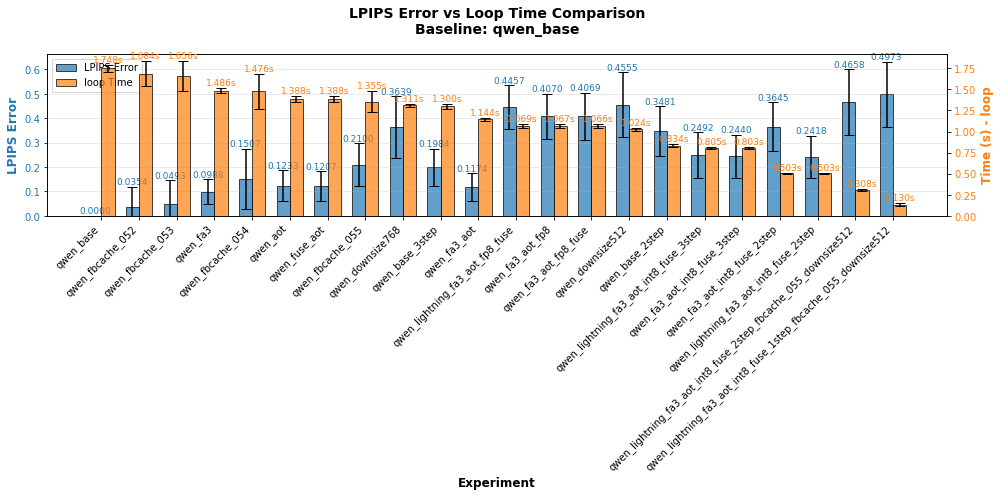

,experiment,lpips_mean,lpips_std,time_mean,time_std
0,qwen_base,0.000000,0.000000,1.748370,0.038003
5,qwen_fbcache_052,0.035377,0.083969,1.683651,0.147396
6,qwen_fbcache_053,0.049340,0.095783,1.656244,0.176397
1,qwen_fa3,0.098819,0.050530,1.486262,0.024040
7,qwen_fbcache_054,0.150750,0.124720,1.476016,0.204040
2,qwen_aot,0.123254,0.064058,1.387999,0.033911
3,qwen_fuse_aot,0.120702,0.061823,1.387822,0.034065
8,qwen_fbcache_055,0.210041,0.087366,1.355392,0.119775
18,qwen_downsize768,0.363855,0.125979,1.311494,0.014959
11,qwen_base_3step,0.198440,0.076125,1.300353,0.027552


In [8]:
# Example: All optimization experiments
experiment_names = [
    "qwen_base",
    "qwen_fa3",
    "qwen_aot",
    "qwen_fuse_aot",
    "qwen_fa3_aot",
    "qwen_fbcache_052",
    "qwen_fbcache_053",
    "qwen_fbcache_054",
    "qwen_fbcache_055",
    "qwen_fa3_aot_fp8",
    "qwen_fa3_aot_fp8_fuse",
    "qwen_base_3step",
    "qwen_base_2step",
    "qwen_fa3_aot_int8_fuse_3step",
    "qwen_fa3_aot_int8_fuse_2step",

    "qwen_lightning_fa3_aot_int8_fuse_3step",
    "qwen_lightning_fa3_aot_int8_fuse_2step",
    "qwen_lightning_fa3_aot_fp8_fuse",

    "qwen_downsize768",
    "qwen_downsize512",

    "qwen_lightning_fa3_aot_int8_fuse_2step_fbcache_055_downsize512",
    "qwen_lightning_fa3_aot_int8_fuse_1step_fbcache_055_downsize512",
]

df_all = compare_sets_with_timing(
    ExperimentSet.create(*experiment_names),
    profile_target="loop",
    sort_by="time"
)

# Display the combined data
df_all


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


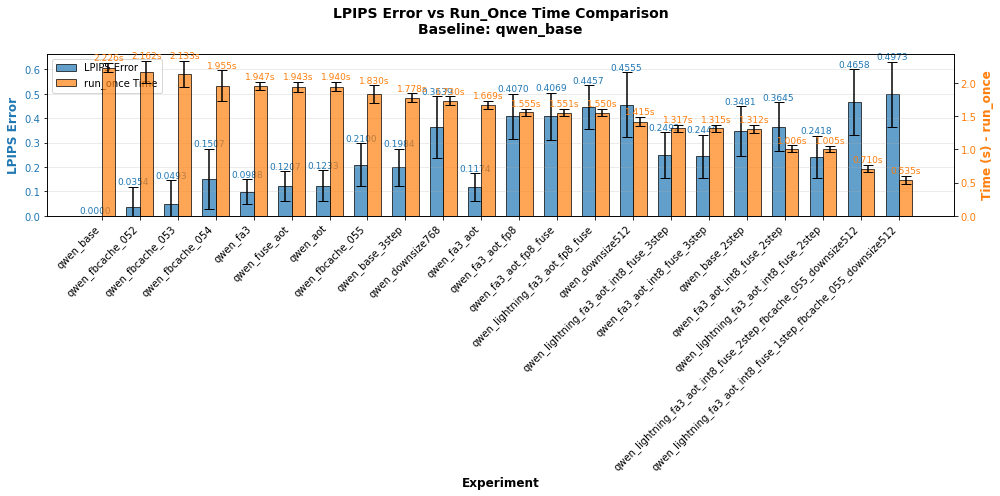

,experiment,lpips_mean,lpips_std,time_mean,time_std
0,qwen_base,0.000000,0.000000,2.225736,0.067141
5,qwen_fbcache_052,0.035377,0.083969,2.162202,0.160729
6,qwen_fbcache_053,0.049340,0.095783,2.133067,0.190319
7,qwen_fbcache_054,0.150750,0.124720,1.955050,0.232325
1,qwen_fa3,0.098819,0.050530,1.947071,0.061501
3,qwen_fuse_aot,0.120702,0.061823,1.942934,0.073606
2,qwen_aot,0.123254,0.064058,1.940447,0.068892
8,qwen_fbcache_055,0.210041,0.087366,1.830056,0.131404
11,qwen_base_3step,0.198440,0.076125,1.777741,0.063624
18,qwen_downsize768,0.363855,0.125979,1.730498,0.064987


In [9]:

compare_sets_with_timing(
    ExperimentSet.create(
       *experiment_names
    ),
    profile_target="run_once",
    match_strategy="contain",
    sort_by="time"
)
